In [190]:
# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv

In [191]:
print(len(np.load('cell_positions_for_training.npy')))


10000


TODO:

Get data from the actual system of interest

PINN!!!

Encoding?

Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [217]:
class CustomGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(CustomGNN, self).__init__()
        # convolutional layer
        self.layer1 = GraphConv(input_dims, hidden_dims)

        # Linear layer
        self.layer2 = Linear(hidden_dims, hidden_dims)

        self.layer3 = Linear(hidden_dims, output_dims)

    def forward(self, feature_data, edge_info, edge_weights):
        # First GCN layer
        x = self.layer1(feature_data, edge_info, edge_weights)
        x = F.relu(x)
        
        # Second GCN layer
        x = self.layer2(x, )
        x = F.relu(x)

        x = self.layer3(x, )
        # x = torch.tanh(x)
        
        return x
    
    

class Enviroment():
    def __init__(self):
        # scatter 1000 points in 2d
        self.ys = [tensor(np.load(f'train_0{i}.npy')).float() for i in range(1, 6)]

        self.y_test = tensor(np.load('cell_positions_for_test.npy')).float()


        self.model = None
        self.optimizer = None

        self.early_stop_count = 0

        self.step_size = 50
        

    def loss_fn(self, out, target):
        return F.mse_loss(out, target) - 0.5*torch.mean(out*out)

    def get_edges(self, positions):
        # create a graph with 1000 nodes
        # create a KD tree for fast nearest neighbor search
        tree = KDTree(positions)
        dists, indices = tree.query(positions, k=10)

        indices[dists > 4.5] = -1

        # create adjacency matrix
        adj_matrix = np.zeros((100, 100))
        for i in range(100):
            for ji, j in enumerate(indices[i]):
                if j == -1:
                    continue
                adj_matrix[i, j] = dists[i, ji]
                adj_matrix[j, i] = dists[i, ji]

        # create edge data
        edges = torch.tensor(np.array(np.where(adj_matrix > 0)), dtype=torch.long).t().contiguous().T
        edge_weights = torch.tensor(adj_matrix[adj_matrix > 0], dtype=torch.float32)

        return edges, edge_weights

    def set_model(self, model):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def call_model(self, X):
        edges, edge_weights = self.get_edges(X)
        return self.model(X, edges, edge_weights)

    def transformation(self, X, target):
        angle = np.random.rand()*2*np.pi
        X = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in X])
        target = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in target])
        
        # scale = 0.5 + 1.5*np.random.rand()
        # X = X*scale
        # target = target*scale
        
        return X, target
    
    def test(self):
        self.model.eval()
        with torch.no_grad():
            avg_loss = torch.tensor(0.0)
            rnge = list(range(0, 1_000-self.step_size, 20))
            for i in rnge:
                X = self.y_test[i]
                target = self.y_test[i+self.step_size] - X

                edges, edge_weights = env.get_edges(X)

                out = self.model(X, edges, edge_weights)

                loss = self.loss_fn(out, target)

                avg_loss += loss.item()

            avg_loss /= len(rnge)

            print('Test loss:', avg_loss.item())

        return avg_loss.item()
    
    def check_early_stop(self, avg_loss, test_loss):
        if test_loss < avg_loss:
            self.early_stop_count = 0
            return False

        if self.early_stop_count >= 3:
            return True
        
        self.early_stop_count += 1
        return False
        



    def train(self, epochs):
        assert self.model is not None, "Model is not initialized"

        # train the model
        self.model.train()
        for epoch in range(1,epochs+1):
            loss = torch.tensor(0.0)
            avg_loss = torch.tensor(0.0)
            print((epoch)%5 if (epoch)%5 !=0 else 5, end='\r')
            for yy in self.ys:
                steps = list(range(0, len(yy)-500-self.step_size, 5))
                for i in steps:
                    X = yy[i]
                    target = yy[i+self.step_size] - X

                    X, target = self.transformation(X, target)

                    self.optimizer.zero_grad()

                    out = self.call_model(X)

                    loss = self.loss_fn(out, target) 

                    loss.backward()
                    self.optimizer.step()
                    avg_loss += loss.item()
            
            avg_loss /= len(steps)

            avg_loss = avg_loss.item()

            if epoch % 5 == 0:
                print(epoch)
                print(f"{epoch/epochs:.3} loss:", avg_loss)
                test_loss = self.test()
                if self.check_early_stop(avg_loss, test_loss):
                    print('Early stoppping')
                    break



# create a GNN model
model = CustomGNN(2, 16, 2)

# create a training enviroment
env = Enviroment()

env.set_model(model)

env.train(5000)

5
0.001 loss: 0.12195228040218353
Test loss: 0.01823236234486103
10
0.002 loss: 0.10840657353401184
Test loss: 0.018237221986055374
15
0.003 loss: 0.11142510175704956
Test loss: 0.018737392500042915
20
0.004 loss: 0.11698003113269806
Test loss: 0.018780698999762535
25
0.005 loss: 0.11877850443124771
Test loss: 0.017933590337634087
30
0.006 loss: 0.12455601990222931
Test loss: 0.0196575578302145
35
0.007 loss: 0.12346339970827103
Test loss: 0.019678739830851555
40
0.008 loss: 0.12313849478960037
Test loss: 0.019640566781163216
45
0.009 loss: 0.12354423850774765
Test loss: 0.019747493788599968
50
0.01 loss: 0.1223989874124527
Test loss: 0.019777847453951836
55
0.011 loss: 0.12382878363132477
Test loss: 0.01985894702374935
60
0.012 loss: 0.12259535491466522
Test loss: 0.01957414485514164
65
0.013 loss: 0.12186316400766373
Test loss: 0.019380366429686546
70
0.014 loss: 0.12232018262147903
Test loss: 0.019538220018148422
75
0.015 loss: 0.12038019299507141
Test loss: 0.018923064693808556
80


KeyboardInterrupt: 

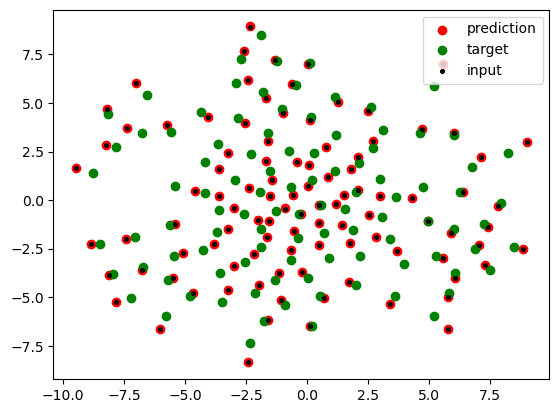

In [215]:
model.train(False)


y = tensor(np.load('cell_positions_for_test.npy')).float()


i = 10
y_true = y[i+30]
X_test = y[i]

# rotate all positions 90 degrees
# X_test = torch.tensor([[x[1], -x[0]] for x in X_test])
# y_true = torch.tensor([[x[1], -x[0]] for x in y_true])

edges, edge_weights = env.get_edges(X_test)

out = model(X_test, edges, edge_weights).detach().numpy()

X_test = X_test.detach().numpy()
y_true = y_true.detach().numpy()

pred = out + X_test

# diff = y_true - pred

plt.scatter(pred[:, 0], pred[:, 1], c='r', label='prediction')
plt.scatter(y_true[:, 0], y_true[:, 1], c='g', label='target')

# plt.quiver(pred[:, 0], pred[:, 1], diff[:, 0], diff[:, 1], angles='xy', scale_units='xy', scale=1)


plt.scatter(X_test[:, 0], X_test[:, 1], c='black', label='input', s = 7, alpha=1)

plt.legend()

# plt.xlim(-1., 1.)
